In [ ]:
from google.colab import drive
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras import layers 
from tensorflow.keras import Model

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/dataset/split_dataset30%.zip'
zip_ref   = zipfile.ZipFile(path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
TRAINING_PATH = '/content/split_dataset30%/train/'
VALIDATION_PATH = '/content/split_dataset30%/val/'

In [ ]:
train_bika_ambon_path = os.path.join(TRAINING_PATH, 'bika_ambon')
train_serabi_path = os.path.join(TRAINING_PATH, 'serabi')
validation_bika_path = os.path.join(VALIDATION_PATH, 'bika_ambon')
validation_serabi_path = os.path.join(VALIDATION_PATH, 'serabi')

In [ ]:
train_bika = os.listdir(train_bika_ambon_path)
print(train_bika[:10])

train_serabi = os.listdir(train_serabi_path)
print(train_serabi[:10])

validation_bika = os.listdir(validation_bika_path)
print(validation_bika[:10])

validation_serabi = os.listdir(validation_serabi_path)
print(validation_serabi[:10])

['bika_ambon_00000165.jpg', 'bika_ambon_00000085.jpg', 'bika_ambon_00000030.jpg', 'bika_ambon_00000089.jpg', 'bika_ambon_00000128.jpg', 'bika_ambon_00000133.jpg', 'bika_ambon_00000082.jpg', 'bika_ambon_00000159.jpg', 'bika_ambon_00000195.jpg', 'bika_ambon_00000223.jpg']
['serabi_00000002.jpg', 'serabi_00000144.jpg', 'serabi_00000243.jpg', 'serabi_00000132.jpg', 'serabi_00000036.jpg', 'serabi_00000104.jpg', 'serabi_00000126.jpg', 'serabi_00000046.jpg', 'serabi_00000120.jpg', 'serabi_00000220.jpg']
['bika_ambon_00000109.jpg', 'bika_ambon_00000001.jpg', 'bika_ambon_00000135.jpg', 'bika_ambon_00000068.jpg', 'bika_ambon_00000023.jpg', 'bika_ambon_00000217.jpg', 'bika_ambon_00000084.jpg', 'bika_ambon_00000246.jpg', 'bika_ambon_00000166.jpg', 'bika_ambon_00000257.jpg']
['serabi_00000149.jpg', 'serabi_00000163.jpg', 'serabi_00000109.jpg', 'serabi_00000001.jpg', 'serabi_00000151.jpg', 'serabi_00000050.jpg', 'serabi_00000067.jpg', 'serabi_00000181.jpg', 'serabi_00000110.jpg', 'serabi_00000145.jp

In [ ]:
%matplotlib inline
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

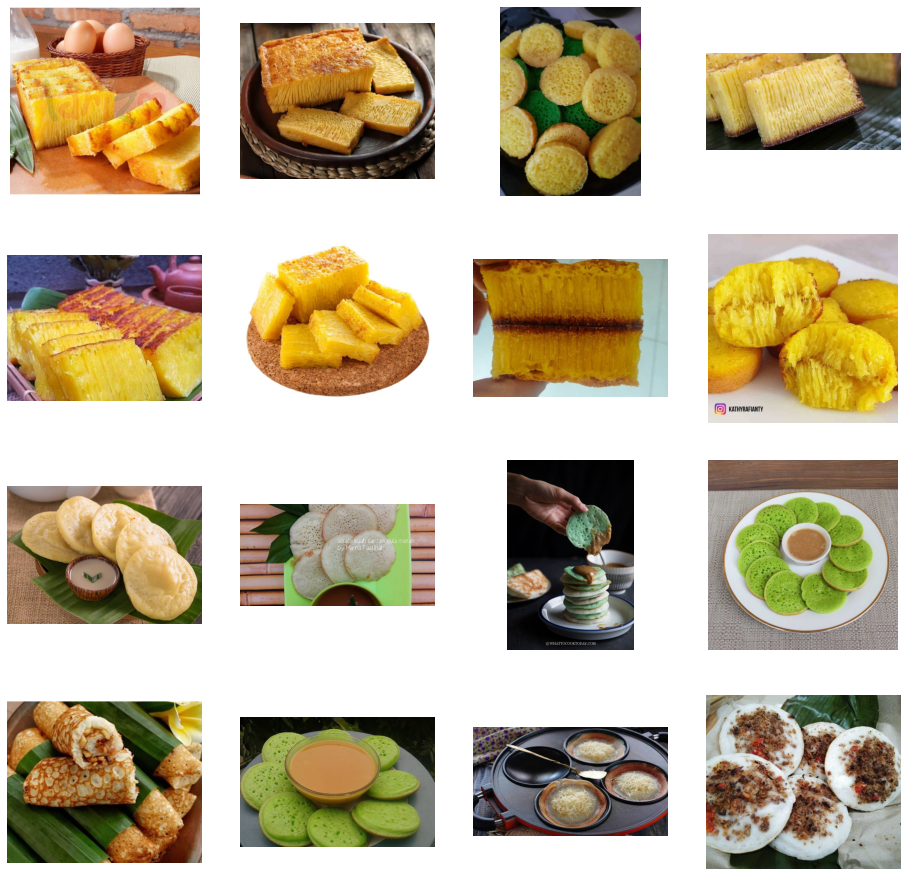

In [ ]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_paper_pic = [os.path.join(train_bika_ambon_path, fname) 
                for fname in train_bika[pic_index-8:pic_index]]
next_plastic_pic = [os.path.join(train_serabi_path, fname) 
                for fname in train_serabi[pic_index-8:pic_index]]

for i, img_path in enumerate(next_paper_pic + next_plastic_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
def train_val_generators(TRAINING_PATH, VALIDATION_PATH):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range = 40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    
    train_generator = train_datagen.flow_from_directory(TRAINING_PATH,
                                                        target_size=(224, 224),
                                                        class_mode='categorical',
                                                        batch_size=64
                                                        )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_directory(
                                                                VALIDATION_PATH,
                                                                target_size=(224, 224),
                                                                class_mode='categorical',
                                                                batch_size=64
                                                                )

    return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(TRAINING_PATH, VALIDATION_PATH)

Found 1871 images belonging to 15 classes.
Found 810 images belonging to 15 classes.


# Pre-Trained Inception

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
base_model = InceptionV3(input_shape= (150, 150, 3), include_top=False, weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(15, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
optimizers = Adam(learning_rate= 0.001)
model.compile(optimizer= optimizers,
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

# Pre Trained VGG-16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
base_model = VGG16(input_shape = (224, 224, 3),
                   include_top = False,
                   weights = 'imagenet')

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(15, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
optimizers = Adam(learning_rate= 0.0001)
model.compile(optimizer= optimizers,
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 30
                    #callbacks = callbacks
                    )

Epoch 1/30
30/30 [==============================] - 49s 2s/step - loss: 2.6504 - accuracy: 0.1507 - val_loss: 2.2518 - val_accuracy: 0.3235
Epoch 2/30
30/30 [==============================] - 47s 2s/step - loss: 2.2413 - accuracy: 0.3089 - val_loss: 1.9234 - val_accuracy: 0.3975
Epoch 3/30
30/30 [==============================] - 47s 2s/step - loss: 2.0255 - accuracy: 0.3731 - val_loss: 1.7204 - val_accuracy: 0.4617
Epoch 4/30
30/30 [==============================] - 47s 2s/step - loss: 1.8605 - accuracy: 0.4164 - val_loss: 1.5244 - val_accuracy: 0.5519
Epoch 5/30
30/30 [==============================] - 47s 2s/step - loss: 1.7170 - accuracy: 0.4703 - val_loss: 1.3897 - val_accuracy: 0.6062
Epoch 6/30
30/30 [==============================] - 47s 2s/step - loss: 1.6388 - accuracy: 0.5051 - val_loss: 1.2869 - val_accuracy: 0.6457
Epoch 7/30
30/30 [==============================] - 48s 2s/step - loss: 1.5347 - accuracy: 0.5339 - val_loss: 1.2263 - val_accuracy: 0.6309
Epoch 8/30
30/30 [==

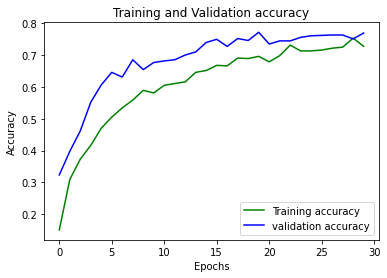

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(30)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

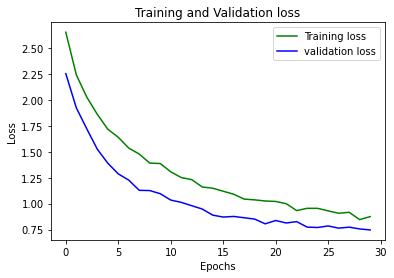

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(30)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
optimizers = Adam(learning_rate= 0.001)
model.compile(optimizer= optimizers,
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 20
                    #callbacks = callbacks
                    )

In [ ]:
labels = ['bika_ambon', 'gudeg', 'gulai_ayam', 'kerak_telor', 'klepon', 'martabak', 'nasi_tumpeng', 'pecel', 'pempek', 'rawon', 'rendang', 'sate', 'serabi', 'soto_ayam', 'tahu_gejrot']
food= {}

for i in range(len(labels)):
    food[labels[i]] = i
food

{'bika_ambon': 0,
 'gudeg': 1,
 'gulai_ayam': 2,
 'kerak_telor': 3,
 'klepon': 4,
 'martabak': 5,
 'nasi_tumpeng': 6,
 'pecel': 7,
 'pempek': 8,
 'rawon': 9,
 'rendang': 10,
 'sate': 11,
 'serabi': 12,
 'soto_ayam': 13,
 'tahu_gejrot': 14}

In [ ]:
pred = model.predict(validation_generator)

In [ ]:
pred.shape

(542, 15)

In [ ]:
pred[212]

array([6.8345559e-03, 4.5185974e-03, 2.1669111e-01, 1.5487618e-05,
       1.7553593e-06, 9.9606252e-05, 2.7311873e-05, 2.1518438e-06,
       3.0659754e-02, 5.0741324e-05, 1.3926445e-04, 7.4714380e-06,
       6.0121121e-05, 8.7322434e-04, 7.4001890e-01], dtype=float32)

TypeError: ignored

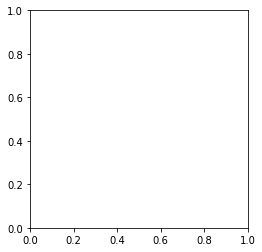

In [ ]:
plt.figure()
plt.imshow(pred[212])
plt.colorbar()
plt.show()

In [ ]:
from imutils import paths
path_test = []
for imagePath in paths.list_images(VALIDATION_PATH):
    path_test.append(os.path.join(VALIDATION_PATH, imagePath))

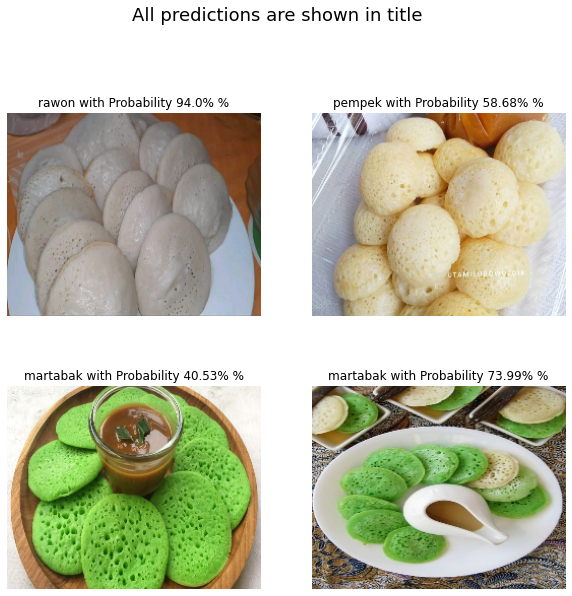

In [ ]:
fig, axs= plt.subplots(2,2, figsize=[10,10])
fig.subplots_adjust(hspace=.01)


count=0
for i in range(2):    
    for j in range(2):  
        
        img = cv2.imread(path_test[count])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = cv2.resize(img, (250,200))
        result = np.argsort(pred[count])[::-1]
        
        i_max = -1
        max_val = ""
        for (k,val) in enumerate(food.keys()):
            
            if(pred[count][k] > i_max):
                i_max = pred[count][k]
                max_val = val
        
        txt = str(max_val) + " with Probability "+ str("{:.4}%".format(i_max*100)) + " %"
            
        
        axs[i][j].imshow(img)
        axs[i][j].set_title(txt)
        axs[i][j].axis('off')

        count+=1
        
plt.suptitle("All predictions are shown in title", fontsize = 18)        
plt.show()